
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [49]:
import pandas as pd

import numpy as np
## Load the data into a DataFrame
liquor = pd.read_csv('../../../../Iowa_Liquor_sales_sample_10pct.csv',low_memory=False)[['Store Number',
               'Date',
               'City',
               'Zip Code',
               'County',
               'Bottle Volume (ml)', 
               'State Bottle Cost', 
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)', 
               'Volume Sold (Liters)', 
               'Volume Sold (Gallons)']]


In [52]:
## Make necessary column modifications

## Transform the dates
liquor["Date"] = pd.to_datetime(liquor["Date"], format="%m/%d/%Y")

## I'm creating functions for a few different things
## that I'll be able to reuse when I import the full dataset
def  clean_columns(table):
    table.columns = [x.replace(' ', '_') for x in table.columns]
    table.columns = [x.replace(')', '') for x in table.columns]
    table.columns = [x.replace('(', '') for x in table.columns]
    table.columns = [x.lower()  for x in table.columns]  
    table.city = liquor.city.str.upper()   #capitalize all cities and counties
    table.county = table.county.str.upper()
    ## remove dollar sign from monetary columns and convert to float
    for column in ('sale_dollars', 'state_bottle_retail', 'state_bottle_cost'):
        table[column] = table[column].str.replace('$','').astype(np.float64)
    ## convert to float
    table['bottles_sold'] = table['bottles_sold'].astype(np.float64)

clean_columns(liquor)

In [53]:
## check: missing values, dtypes, df shape, describe, unique values, duplicates

def eda(dataframe):
    
    print "missing values \n", dataframe.isnull().sum()## count number of null values per column
    print ''
    print "dataframe types \n", dataframe.dtypes       ## list data type of each column
    print ''
    print "dataframe shape \n", dataframe.shape        ## rows by columns
    print ''
    print "dataframe describe \n", dataframe.describe()## stats -- mean, min, max, etc.. 
    print ''
    for item in dataframe:                             ## count number of unique values per column
        print item, '= ', dataframe[item].nunique()
    print ''
    print 'num duplicates:', dataframe.duplicated().sum()

eda(liquor)

missing values 
store_number              0
date                      0
city                      0
zip_code                  0
county                 1077
bottle_volume_ml          0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sale_dollars              0
volume_sold_liters        0
volume_sold_gallons       0
dtype: int64

dataframe types 
store_number                    int64
date                   datetime64[ns]
city                           object
zip_code                       object
county                         object
bottle_volume_ml                int64
state_bottle_cost             float64
state_bottle_retail           float64
bottles_sold                  float64
sale_dollars                  float64
volume_sold_liters            float64
volume_sold_gallons           float64
dtype: object

dataframe shape 
(270955, 12)

dataframe describe 
        store_number  bottle_volume_ml  state_bottle_cost  \
count  270955.000000     270955.00

In [54]:
## As a result of the EDA function, 
## I will drop duplicates
## & fill in county names

## drop duplicate rows
liquor.drop_duplicates(inplace=True)
print 'num duplicates:', liquor.duplicated().sum()

## create a lookup table for all filled in counties, zip_codes
## that can be used to fill in any counties have a zip code but no name
county_lookup = liquor[['zip_code','county']][liquor.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)   # make sure there's only one of each county, drop dupes

## in addition to the lookup table, I'm using the file below
## to help fill in missing county names
iowa_zips = pd.read_csv('../../../../iowa_zips.csv')
iowa_zips.columns = [c.replace(' ', '_') for c in iowa_zips.columns]

## next cell will update county names


num duplicates: 0


In [55]:
## I spent a while trying to figure out how to update
## values in the pandas dataframe, but was very
## unsuccessful. I decided to run the updates using SQL instead.

## set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

## push dataframes into sql tables
liquor.to_sql('liquor', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)

## run updates to fill in county names by matching zip_codes to lookup data
conn.execute("update liquor set county = (select upper(county) from county_lookup where county_lookup.zip_code = liquor.zip_code) where county is null;")
conn.execute("update liquor set county = (select upper(County) from iowa_zips where iowa_zips.Zip_Code = liquor.zip_code) where county is null;")

## pull sql table back into a pandas df
liquor_sql = pd.read_sql_table('liquor',engine)

## close sql connection
conn.close()

In [56]:
## check missing values for counties to see how many are null now
eda(liquor_sql)
## all are filled in!

## I'm happy with the quality of the data, so I'm
## going to go ahead and use the modified table
liquor = liquor_sql
liquor_sql = ''

missing values 
index                  0
store_number           0
date                   0
city                   0
zip_code               0
county                 0
bottle_volume_ml       0
state_bottle_cost      0
state_bottle_retail    0
bottles_sold           0
sale_dollars           0
volume_sold_liters     0
volume_sold_gallons    0
dtype: int64

dataframe types 
index                           int64
store_number                    int64
date                   datetime64[ns]
city                           object
zip_code                       object
county                         object
bottle_volume_ml                int64
state_bottle_cost             float64
state_bottle_retail           float64
bottles_sold                  float64
sale_dollars                  float64
volume_sold_liters            float64
volume_sold_gallons           float64
dtype: object

dataframe shape 
(268501, 13)

dataframe describe 
               index   store_number  bottle_volume_ml  state_bottle_

In [57]:
## now that all counties are filled in, export data to be used for mapping in tableau
liquor.to_csv('../../../../Iowa_Liquor_sales_sample_10pct_CLEAN.csv') 


## because i'm neurotic, found coordinates for counties that couldn't be mapped in tableau
# https://dom.iowa.gov/document/iowa-county-codes-and-coordinates

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

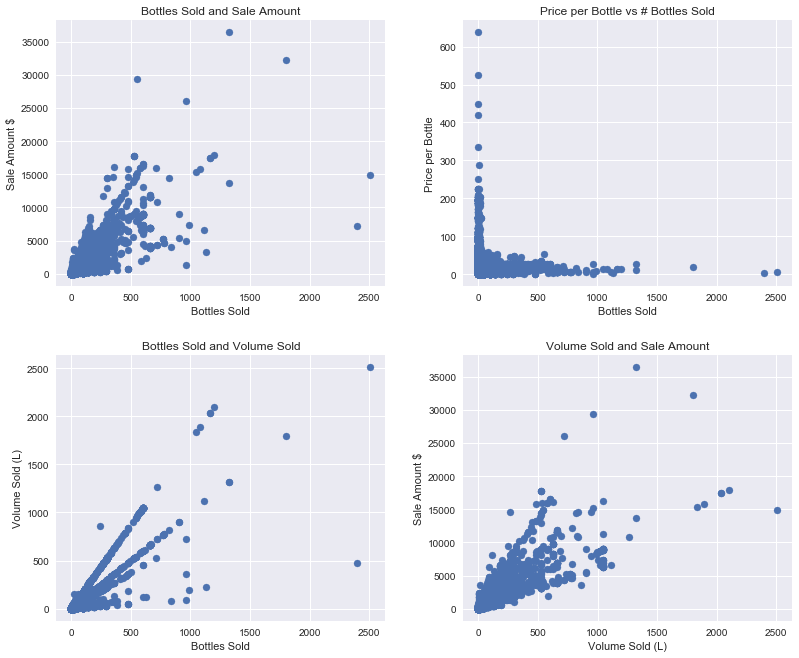

In [61]:
plt.close('all')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
plt.tight_layout(pad=5, w_pad=5, h_pad=5)

ax1.scatter(liquor.bottles_sold,liquor.sale_dollars)
ax1.set_xlabel('Bottles Sold')
ax1.set_ylabel('Sale Amount $')
ax1.set_title('Bottles Sold and Sale Amount')

ax2.scatter(liquor.bottles_sold,liquor.state_bottle_retail)
ax2.set_xlabel('Bottles Sold')
ax2.set_ylabel('Price per Bottle')
ax2.set_title('Price per Bottle vs # Bottles Sold')

ax3.scatter(liquor.bottles_sold,liquor.volume_sold_liters)
ax3.set_xlabel('Bottles Sold')
ax3.set_ylabel('Volume Sold (L)')
ax3.set_title('Bottles Sold and Volume Sold')

ax4.scatter(liquor.volume_sold_liters,liquor.sale_dollars)
ax4.set_xlabel('Volume Sold (L)')
ax4.set_ylabel('Sale Amount $')
ax4.set_title('Volume Sold and Sale Amount')

In [ ]:
g = sns.FacetGrid(liquor, col='sale_dollars')  
g.map(sns.distplot, "mpg")  

# Record your findings

Be sure to write out any observations from your exploratory analysis.


# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


In [ ]:
by_store = liquor[['store_number',
                   'quarter',
                   'sale_dollars',
                   'volume_sold_liters',
                   'bottles_sold']].groupby(['store_number',
                                             'quarter']).agg({'sale_dollars': [np.sum, np.mean],
                                                            'volume_sold_liters': [np.sum, np.mean],
                                                            'bottles_sold' : [np.sum, np.mean]
                                                           
                                                           })
by_county = liquor[['county',
                   'quarter',
                   'sale_dollars',
                   'volume_sold_liters',
                   'bottles_sold']].groupby(['county',
                                             'quarter']).agg({'sale_dollars': [np.sum, np.mean],
                                                            'volume_sold_liters': [np.sum, np.mean],
                                                            'bottles_sold' : [np.sum, np.mean]
                                                           })

by_city = liquor[['city',
                   'quarter',
                   'sale_dollars',
                   'volume_sold_liters',
                   'bottles_sold']].groupby(['city',
                                             'quarter']).agg({'sale_dollars': [np.sum, np.mean],
                                                            'volume_sold_liters': [np.sum, np.mean],
                                                            'bottles_sold' : [np.sum, np.mean]
                                                           })

In [ ]:
sns.pairplot(by_store)

In [ ]:
sns.pairplot(by_county)

In [ ]:
sns.pairplot(by_city)


# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [ ]:
liquor_by_store = liquor[['store_number',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail']].groupby(liquor.store_number).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum})

liquor_by_zip = liquor[['zip_code',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.zip_code).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                                   'store_number' : lambda x: x.nunique()})
liquor_by_city = liquor[['city',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.city).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                           'store_number' : lambda x: x.nunique()})
liquor_by_county = liquor[['county',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                          'store_number']].groupby(liquor.county).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                             'store_number' : lambda x: x.nunique()})


liquor_by_store['avg_price_per_bottle'] = liquor_by_store.sale_dollars / liquor_by_store.bottles_sold
liquor_by_zip['avg_price_per_bottle'] = liquor_by_zip.sale_dollars / liquor_by_zip.bottles_sold
liquor_by_city['avg_price_per_bottle'] = liquor_by_city.sale_dollars / liquor_by_city.bottles_sold
liquor_by_county['avg_price_per_bottle'] = liquor_by_county.sale_dollars / liquor_by_county.bottles_sold

liquor_by_zip['avg_sales_store'] = liquor_by_zip.sale_dollars / (liquor_by_zip.bottles_sold)
liquor_by_city['avg_sales_store'] = liquor_by_city.sale_dollars / (liquor_by_city.bottles_sold)
liquor_by_county['avg_sales_store'] = liquor_by_county.sale_dollars / (liquor_by_county.bottles_sold)

liquor_by_zip['avg_sales_store_plus1'] = liquor_by_zip.sale_dollars / (liquor_by_zip.bottles_sold + 1)
liquor_by_city['avg_sales_store_plus1'] = liquor_by_city.sale_dollars / (liquor_by_city.bottles_sold + 1)
liquor_by_county['avg_sales_store_plus1'] = liquor_by_county.sale_dollars / (liquor_by_county.bottles_sold + 1)

liquor_by_zip['delta_sales'] = liquor_by_zip.avg_sales_store - liquor_by_zip.avg_sales_store_plus1
liquor_by_city['delta_sales'] = liquor_by_city.avg_sales_store - liquor_by_city.avg_sales_store_plus1
liquor_by_county['delta_sales'] = liquor_by_county.avg_sales_store - liquor_by_county.avg_sales_store_plus1

In [ ]:
sns.pairplot(liquor_by_store)

In [ ]:
sns.pairplot(liquor_by_zip)

In [ ]:
sns.pairplot(liquor_by_city)

In [ ]:
sns.pairplot(liquor_by_county)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
import statsmodels.formula.api as sm #import statsmodels

In [ ]:

X = liquor_desmoines[['bottles_sold','state_bottle_retail']]
y = liquor_desmoines['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_desmoines = lm.fit(X,y)
print model_desmoines.score(X,y)
print model_desmoines.alpha_

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score


liquor_by_zip.sort_values('sale_dollars',ascending=False)
liquor_50314 = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.zip_code=='50314'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X = liquor_50314[['bottles_sold','state_bottle_retail']]
y = liquor_50314['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_50314 = lm.fit(X,y)
print '50314 model score = ', model_50314.score(X,y)
print '50314 alpha =', model_50314.alpha_
print ''


liquor_50320 = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.zip_code=='50320'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
                                                                                                         
X = liquor_50320[['bottles_sold','state_bottle_retail']]
y = liquor_50320['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_50320 = lm.fit(X,y)
print '50320 model score =', model_50320.score(X,y)
print '50320 alpha =', model_50320.alpha_
print ''


liquor_desmoines = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.city=='DES MOINES'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X = liquor_desmoines[['bottles_sold','state_bottle_retail']]
y = liquor_desmoines['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_desmoines = lm.fit(X,y)
print 'Des Moines model score = ', model_desmoines.score(X,y)
print 'Des Moines alpha = ', model_desmoines.alpha_

In [ ]:
X = liquor_by_store[['bottles_sold','state_bottle_retail']]
y = liquor_by_store['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model = lm.fit(X,y)
print model.score(X,y)
print model.alpha_
print ''
liquor_by_store['predictions'] = model.predict(X)
print 'TOP PERFORMING STORES'
liquor_by_store[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

In [ ]:
predictions = model_desmoines.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()

In [ ]:
predictions = model_50314.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()


predictions = model_50320.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.